# Genre Predictor by Movie Poster
This project aims to predict the genres of a movie just by analyzing it's poster image.

**Author**: Alexander Ehrenhöfer
**Dataset src**: https://www.kaggle.com/datasets/raman77768/movie-classifier

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.applications import ConvNeXtSmall
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras import backend as K
from keras.layers import *
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve

# Data Preparation
In this section we will inspect the data and prepare it for later training

In [4]:
# Load the CSV file with image file paths and corresponding genres
csv_path = 'data/Multi_Label_dataset/train.csv'
df = pd.read_csv(csv_path)

# Define paths to the directory containing movie posters
image_dir = 'data/Multi_Label_dataset/Images/'

# Join the directory path with the image filenames
df['image_path'] = df['Id'].apply(lambda x: image_dir + x + '.jpg')

all_genres = df.columns[2:-3]

In [5]:
print('---- basic structure of the data ----')
df.head(5)

---- basic structure of the data ----


,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,image_path,genre_array,first_genre
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086425.jpg,"[Comedy, Drama]",Comedy
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0085549.jpg,"[Drama, Romance, Music]",Drama
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086465.jpg,[Comedy],Comedy
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,data/Multi_Label_dataset/Images/tt0086567.jpg,"[Sci-Fi, Thriller]",Sci-Fi
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,data/Multi_Label_dataset/Images/tt0086034.jpg,"[Action, Adventure, Thriller]",Action


In [6]:
df.dtypes

Id             object
Genre          object
Action          int64
Adventure       int64
Animation       int64
Biography       int64
Comedy          int64
Crime           int64
Documentary     int64
Drama           int64
Family          int64
Fantasy         int64
History         int64
Horror          int64
Music           int64
Musical         int64
Mystery         int64
N/A             int64
News            int64
Reality-TV      int64
Romance         int64
Sci-Fi          int64
Short           int64
Sport           int64
Thriller        int64
War             int64
Western         int64
image_path     object
genre_array    object
first_genre    object
dtype: object

---- Genre Distribution with multi genre possibility  ----


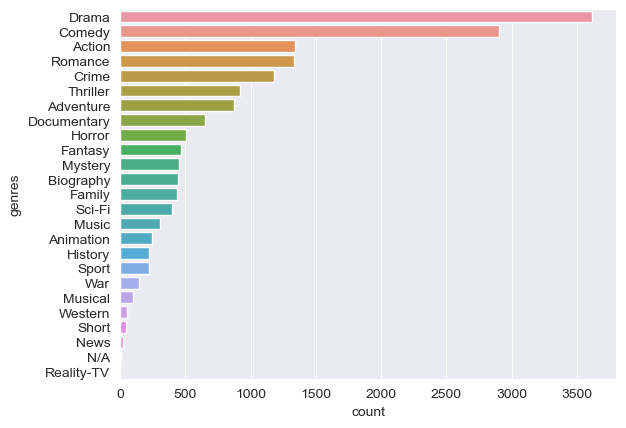

In [7]:
print('---- Genre Distribution with multi genre possibility  ----')

def print_genre_occurence(dataframe):
    genre_count = [len(dataframe[df[genre] == 1]) for genre in all_genres]
    genre_count_df = pd.DataFrame({
        'genres': all_genres,
        'count': genre_count
    })
    genre_count_df = genre_count_df.sort_values(by='count', ascending=False)
    sns.barplot(orient='horizontal', x='count', y='genres', data=genre_count_df)

print_genre_occurence(df)

In [4]:
genres_to_predict = ['Action', 'Romance', 'Crime', 'Thriller', 'Adventure', 'Documentary', 'Horror', 'Fantasy', 'Mystery', 'Family', 'Music', 'Animation', 'History']

### Methods to obtain Data by Genre
While Testing different approaches, we found out that models trained with an output as one neuron per genre (25 output neurons) were not able to reach satisying results. So we decided to train a model for every genre just with one output neuron decidicing wether the given poster seems to be that genre or not

The following two method return the filtered, balanced data for a given genre. The first method `get_data_generator_by_genre` is not used anymore but is kept in the code to show the possibility of Image Generators of Keras.

In [9]:
def get_data_generator_by_genre(data_frame, genre):
    positive_data = data_frame[data_frame[genre] == 1]
    negative_data = data_frame[data_frame[genre] == 0]

    # make sure data is balanced
    if len(positive_data) > len(negative_data):
        positive_data = positive_data[0:len(negative_data)]
    else:
        negative_data = negative_data[0:len(positive_data)]

    complete_data = pd.concat([positive_data, negative_data])
    complete_data[genre] = complete_data[genre].astype(str)

    print('--- data for genre specific model ---')
    print('num ' + genre + ' == 1: ' + str(len(complete_data[complete_data[genre] == '1'])))
    print('num ' + genre + ' == 0: ' + str(len(complete_data[complete_data[genre] == '0'])))
    print ('--- --- ---')

    train_df, test_df = train_test_split(complete_data, test_size=0.2)

    # create Keras Image Generators
    train_datagen = ImageDataGenerator(
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.25
    )
    test_datagen = ImageDataGenerator()
    batch_size = 32
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col=genre,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        Shuffle=True,
        subset='training',
        validate_filenames=False
    )
    valid_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col=genre,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        Shuffle=True,
        subset='validation',
        validate_filenames=False
    )
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col=genre,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        validate_filenames=False
    )
    return train_generator, valid_generator, test_generator

def get_raw_data_by_genre(data_frame, genre):
    shuffled_frame = copy.copy(data_frame.sample(frac=1))
    positive_data = shuffled_frame[shuffled_frame[genre] == 1]
    negative_data = shuffled_frame[shuffled_frame[genre] == 0]

    # make sure data is balanced
    if len(positive_data) > len(negative_data):
        positive_data = positive_data[0:len(negative_data)]
    else:
        negative_data = negative_data[0:len(positive_data)]

    complete_data = pd.concat([positive_data, negative_data])
    complete_data = complete_data.sample(frac=1)

    print('--- data for genre specific model ---')
    print('num ' + genre + ' == 1: ' + str(len(complete_data[complete_data[genre] == 1])))
    print('num ' + genre + ' == 0: ' + str(len(complete_data[complete_data[genre] == 0])))
    print ('--- --- ---')

    # Input NP Array (Image Data directly as pixel values)
    width = 300
    height = 300
    x_data = []
    for index, row in complete_data.iterrows():
        img = utils.load_img(row['image_path'],target_size=(height,width,3))
        img = utils.img_to_array(img)
        img = img/255.0
        x_data.append(img)

    x_data = np.array(x_data)
    y_data = complete_data[genre]

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)
    x_train, x_val, y_train,y_val = train_test_split(x_train, y_train, test_size=0.15)
    return x_train, x_val, x_test, y_train, y_val, y_test

# CNN Setup
These two models turned out to achieve the best results. The Resnet Model is already pretrained and by using transfer learning as well as some fine tuning we only train the last 2 layers and the fully connected layers based on our needs.
The poster model (based of this source: https://www.kaggle.com/code/krutarthhd/genre-prediction-from-the-movie-poster) is fully trained here.

In [10]:
def get_resnet_model(fine_tune=2):
    #based on https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
    # Load the pre-trained Resnet model
    base_model = ResNet50V2(include_top=False, input_shape=(300, 300, 3))

    # Freeze the layers of the pre-trained model (exclude fine tuning layers)
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
                layer.trainable = False
    else:
        for layer in base_model.layers:
                layer.trainable = False

    # Create a new model for genre prediction
    return Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

def get_poster_model():
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(300, 300, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1,activation='sigmoid'))
    return model

def train_model_image_gen(train_gen, valid_gen, p_model, num_epochs, p_model_filename):
    p_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # Define callbacks
    checkpoint = ModelCheckpoint(p_model_filename,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 monitor='val_loss',
                                 mode='min',
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    # Run the actual training and return training history
    history = p_model.fit(
        train_gen,
        epochs=num_epochs,  # Adjust the number of epochs as needed
        validation_data=valid_gen,
        callbacks=[checkpoint, early_stopping]
    )
    return history

def train_model_raw_data(x_train, x_val, y_train, y_val, p_model, num_epochs, p_model_filename):
    p_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # Define callbacks
    checkpoint = ModelCheckpoint(p_model_filename,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 monitor='val_loss',
                                 mode='min',
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    # Run the actual training and return training history
    history = p_model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=num_epochs,  # Adjust the number of epochs as needed
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, early_stopping]
    )
    return history

# Actual Training
Here we train both models and save a genre-decision-model for each genre.

In [ ]:
# Model for Comedy Prediction
genre_models = {}

for genre in genres_to_predict:
    #train_gen, valid_gen, test_gen = get_data_generator_by_genre(df, genre)
    x_train, x_val, _, y_train, y_val, _ = get_raw_data_by_genre(df, genre)

    genre_models[genre] = {}

    # Custom Poster Model
    model_filename = 'models/movie_genre_model_custom' + genre + '.keras'
    model = get_poster_model()
    history = train_model_raw_data(x_train, x_val, y_train, y_val, model, 15, model_filename)
    model.save(model_filename)
    genre_models[genre]['CustomModel'] =  history

    # ResNet50V2
    model_filename = 'models/movie_genre_model_resnet' + genre + '.keras'
    model = get_resnet_model()
    history = train_model_raw_data(x_train, x_val, y_train, y_val, model, 15, model_filename)
    model.save(model_filename)
    genre_models[genre]['ResNet50V2'] =  history

# Show the training progress

In [ ]:
# Plot training history
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.reset_orig()
for genre in genres_to_predict:
    sns.lineplot(genre_models[genre]['ResNet50V2'].history['accuracy'], label='ResNet50V2 Accuracy ' + genre, ax=ax[0])
    #plt.plot(genre_models[genre]['MobileNet'].history['accuracy'], label='MobileNet Accuracy ' + genre, ax=ax[0])
    sns.lineplot(genre_models[genre]['CustomModel'].history['accuracy'], label='CustomModel Accuracy ' + genre, ax=ax[1])
    #plt.plot(genre_models[genre]['CustomModel'].history['val_accuracy'], label='CustomModel Accuracy ' + genre)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].legend(loc=(0, -1))
ax[1].legend(loc=(0, -1))
plt.show()
plt.close()

# Result Evaluation
Plotting the ROC Curve to see the model performances

In [3]:
def get_model(name, genre):
    file_name = 'models/movie_genre_model_' + str(name) + str(genre) + '.keras'
    return load_model(file_name)

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.reset_orig()
for genre in genres_to_predict:
    # Generate predictions
    _, _, x_test, _, _, y_test = get_raw_data_by_genre(df, genre)
    model_custom = get_model('custom', genre)
    model_resnet = get_model('resnet', genre)
    custom_model_preds = model_custom.predict(x_test)
    resnet_model_preds = model_resnet.predict(x_test)
    # ROC Curve
    fpr1, tpr1, _ = roc_curve(y_test, custom_model_preds)
    fpr2, tpr2, _ = roc_curve(y_test, resnet_model_preds)
    ax[0].plot(fpr1, tpr1, label='custom ' + str(genre))
    ax[1].plot(fpr2, tpr2, label='resnet ' + str(genre))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax[0].legend(loc=(0, -1))
ax[1].legend(loc=(0, -1))
plt.show()
plt.close()

--- data for genre specific model ---
num Action == 1: 1343
num Action == 0: 1343
--- --- ---


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

# Actually using the Model for Predictions
Now we will try the model "in the real world" by plotting the predicted genres of 6 custom posters that are not included in any training data.

In [101]:
images_to_predict = ['bladerunner.jpg', 'interstellar.jpg', 'paddingtion.jpg', 'matrix.png', 'smurfs.jpg', 'imitationgame.jpg']

def get_genre_prediction(filename, p_model):
    # Get Image
    subdir = 'data/download/'
    img = utils.load_img(subdir + filename, target_size=(300,300,3))
    img = utils.img_to_array(img)
    x = img.reshape(1,300,300,3)
    #predict
    model_pred = p_model.predict(x)
    return model_pred[0][0]


poster_predictions = pd.DataFrame({
    'poster': [],
    'genre': [],
    'prediction': []
})

for genre in genres_to_predict:
    K.clear_session()
    model = get_model('resnet', genre)
    print('loaded ' + genre + ' model')
    for poster in images_to_predict:
        pred = get_genre_prediction(poster, model)
        print('Prediction ' + genre + '/' + poster + ': ' + str(pred))
        poster_predictions = pd.concat([poster_predictions, pd.DataFrame([{
            'poster': poster,
            'genre': genre,
            'prediction': pred
        }])], ignore_index=True)

loaded Action model
1/1 [==============================] - 1s 962ms/step
Prediction Action/bladerunner.jpg: 0.0


C:\Users\alex\AppData\Local\Temp\ipykernel_19364\4016017057.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poster_predictions = pd.concat([poster_predictions, pd.DataFrame([{


1/1 [==============================] - 0s 149ms/step
Prediction Action/interstellar.jpg: 0.0
1/1 [==============================] - 0s 136ms/step
Prediction Action/paddingtion.jpg: 0.0
1/1 [==============================] - 0s 127ms/step
Prediction Action/matrix.png: 0.0
1/1 [==============================] - 0s 110ms/step
Prediction Action/smurfs.jpg: 0.0
1/1 [==============================] - 0s 114ms/step
Prediction Action/imitationgame.jpg: 0.0
loaded Romance model
1/1 [==============================] - 1s 926ms/step
Prediction Romance/bladerunner.jpg: 7.126757e-29
1/1 [==============================] - 0s 132ms/step
Prediction Romance/interstellar.jpg: 1.1957742e-32
1/1 [==============================] - 0s 141ms/step
Prediction Romance/paddingtion.jpg: 0.0
1/1 [==============================] - 0s 120ms/step
Prediction Romance/matrix.png: 0.0
1/1 [==============================] - 0s 117ms/step
Prediction Romance/smurfs.jpg: 0.0
1/1 [==============================] - 0s 128ms/ste

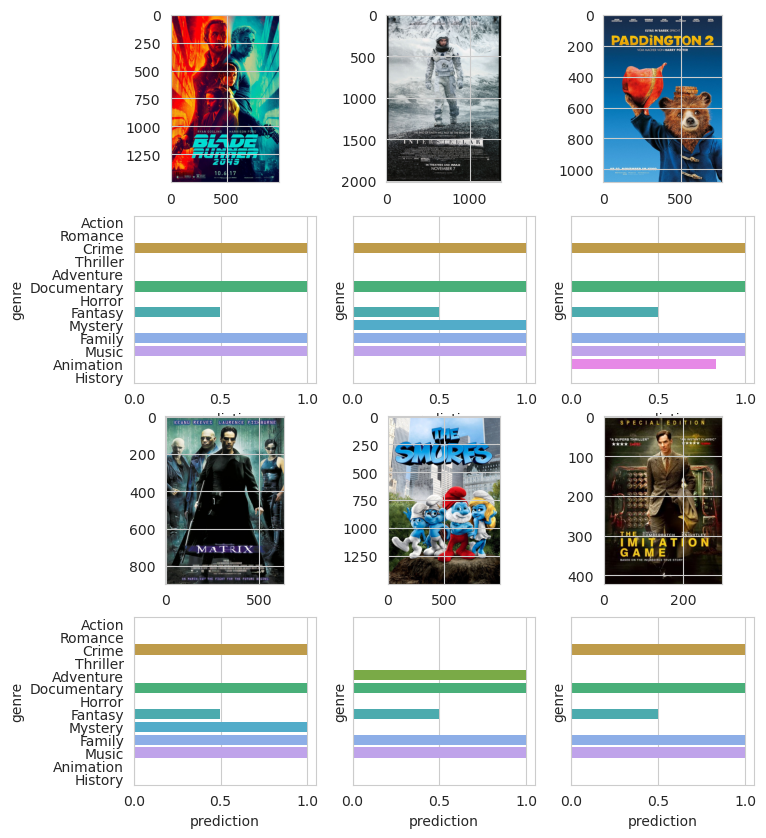

In [175]:
fig, ax = plt.subplots(4,3, figsize=(8, 10))

x_count = 0
y_count = 0
for poster in images_to_predict:
    preds = poster_predictions[poster_predictions['poster'] == poster]
    sns.reset_orig()
    #poster_img = cv2.imread('data/download/' + poster)
    poster_img = cv2.imread('data/download/' + poster, cv2.IMREAD_COLOR)
    poster_img = cv2.cvtColor(poster_img, cv2.COLOR_BGRA2RGB)
    #poster_img = cv2.bitwise_not(poster_img)
    ax[y_count*2, x_count].imshow(poster_img)
    sns.barplot(
        x=preds['prediction'].astype(float),
        y=preds['genre'],
        orientation='horizontal',
        ax=ax[(y_count*2)+1, x_count]
    )
    if x_count > 0:
        ax[(y_count*2)+1, x_count].set_yticks([])

    if x_count >= 2:
        y_count = 1
        x_count = -1
    x_count = x_count + 1

plt.show()
plt.close()


In [13]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
print("Num GPUs Available: ", len(gpus))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())


Num GPUs Available:  0
Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Visualizatin of the Feature Maps
Here we are trying to visualize which part of the poster seem to be relevant for the genre prediction

In [150]:
def get_model_feature_layers(model):
    fig = plt.figure(figsize=(15, 20))
    i = 1
    img = utils.load_img('data/download/interstellar.jpg', target_size=(300,300,3))
    img = utils.img_to_array(img)
    img = img.reshape(1,300,300,3)
    layers = model.layers
    if hasattr(layers[0], 'layers'):
        layers = model.layers[0].layers
    for layer in layers:
        if isinstance(layer, Conv2D) or isinstance(layer, MaxPool2D) or isinstance(layer, ZeroPadding2D):
            try:
                img = layer(img)
            except:
                continue
            output_img = np.squeeze(img)
            output_img = np.sum(output_img, axis=2)
            normalized_image = ((output_img - np.min(output_img)) / (np.max(output_img) - np.min(output_img))) * 255
            a = fig.add_subplot(15, 5, i)
            a.set_title(layer.__class__.__name__)
            imgplot = plt.imshow(normalized_image, cmap='bwr', vmin=0, vmax=255)
            a.axis('off')
            i += 1

    plt.show()
    plt.close()

## For the Custom Model

In [ ]:
model = get_model('custom', 'Adventure')
print('Model: Custom, Genre: Adventure')
get_model_feature_layers(model)

model = get_model('custom', 'Horror')
print('Model: Custom, Genre: Horror')
get_model_feature_layers(model)

model = get_model('custom', 'Family')
print('Model: Custom, Genre: Family')
get_model_feature_layers(model)

print("---- APPLYING FILTERS TO IMAGE -----")

## For the Resnet Model

Model: resnet, Genre: Adventure


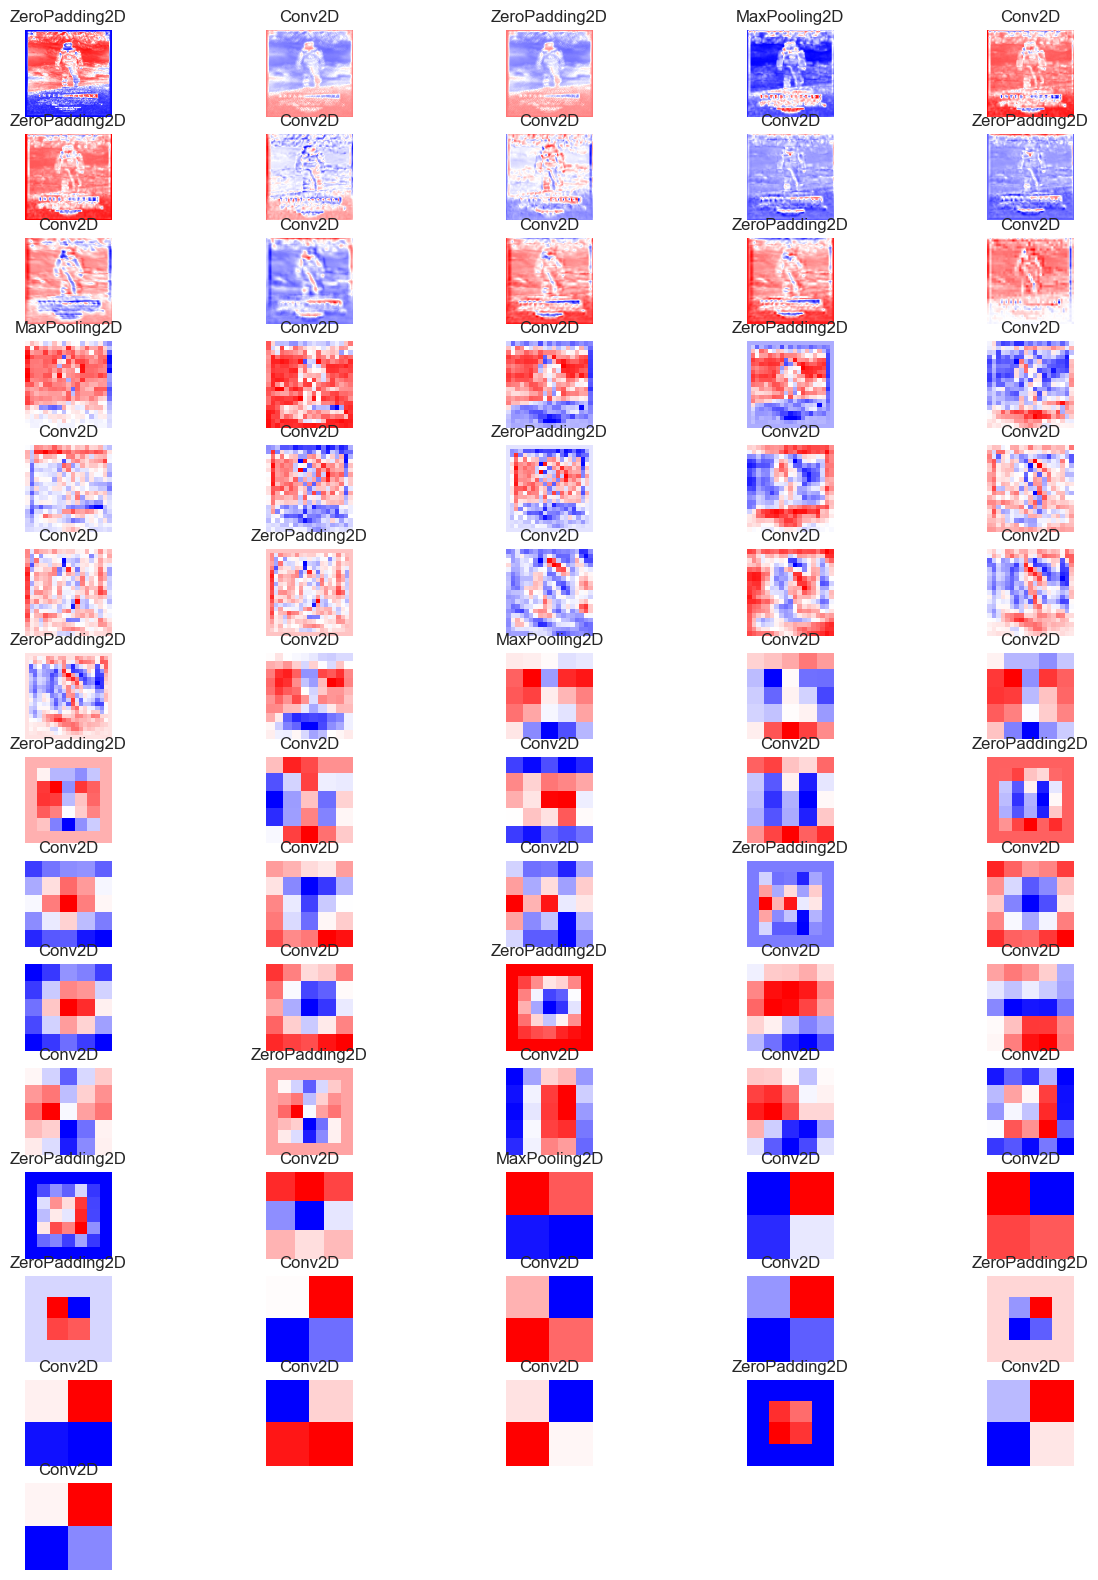

Model: resnet, Genre: Horror


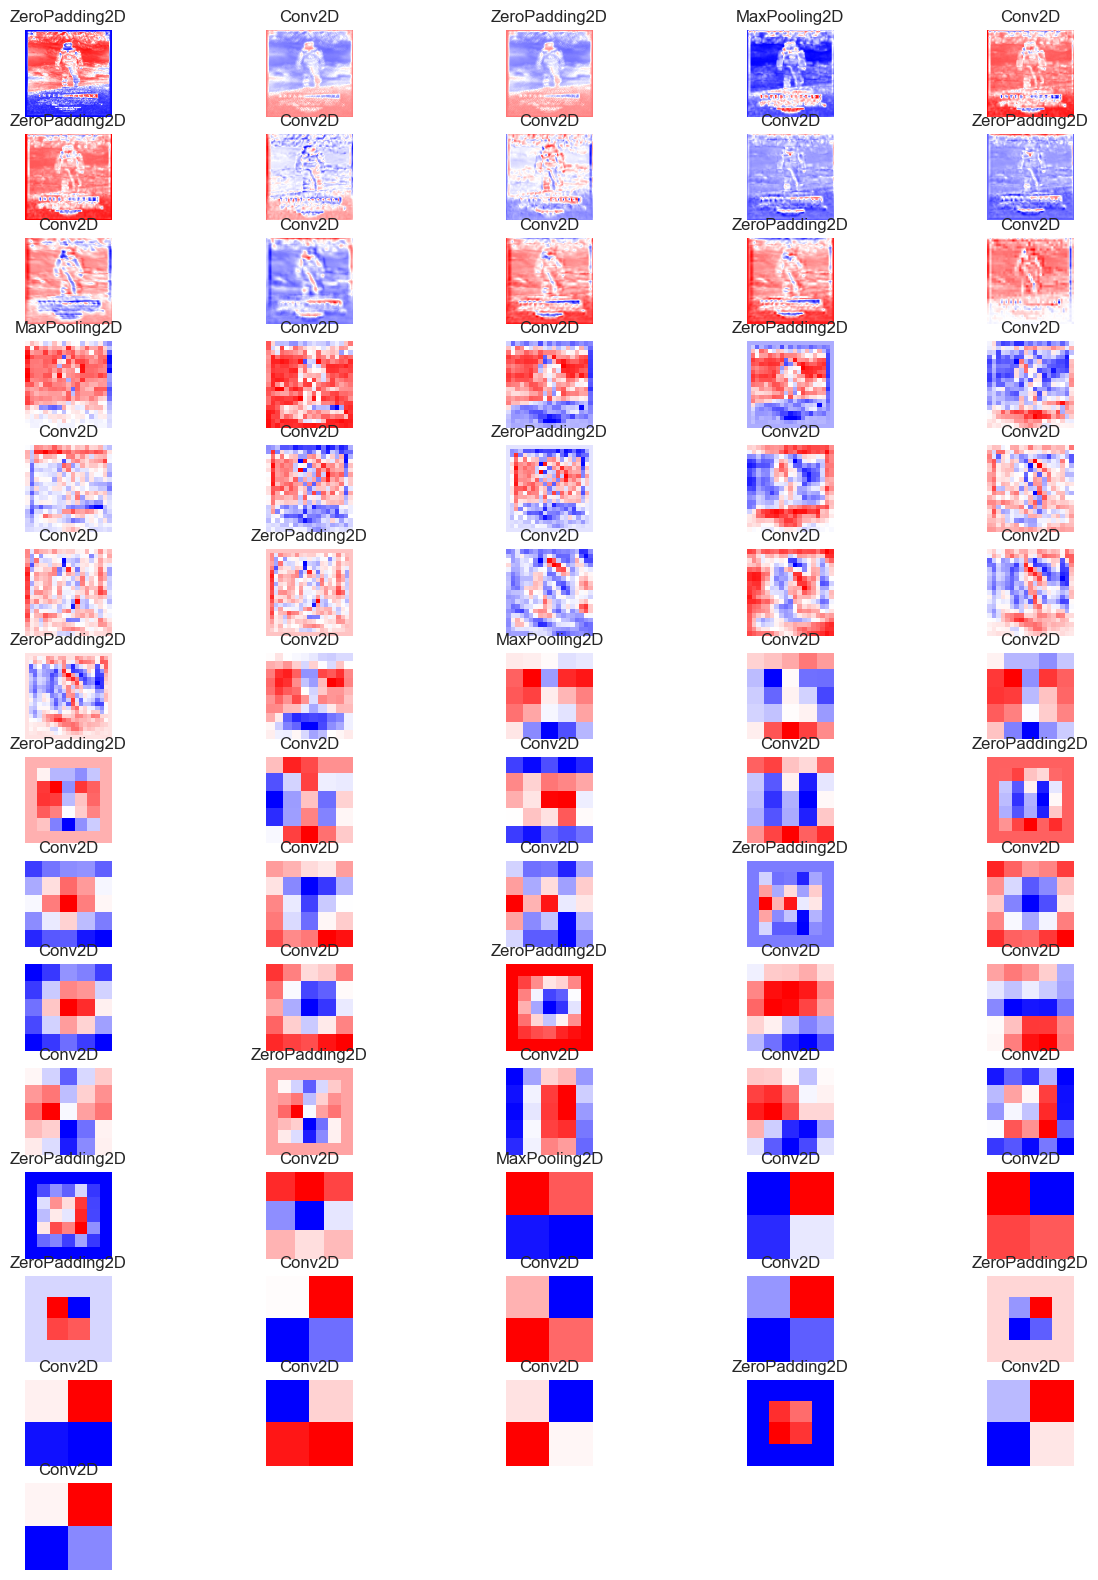

Model: resnet, Genre: Family


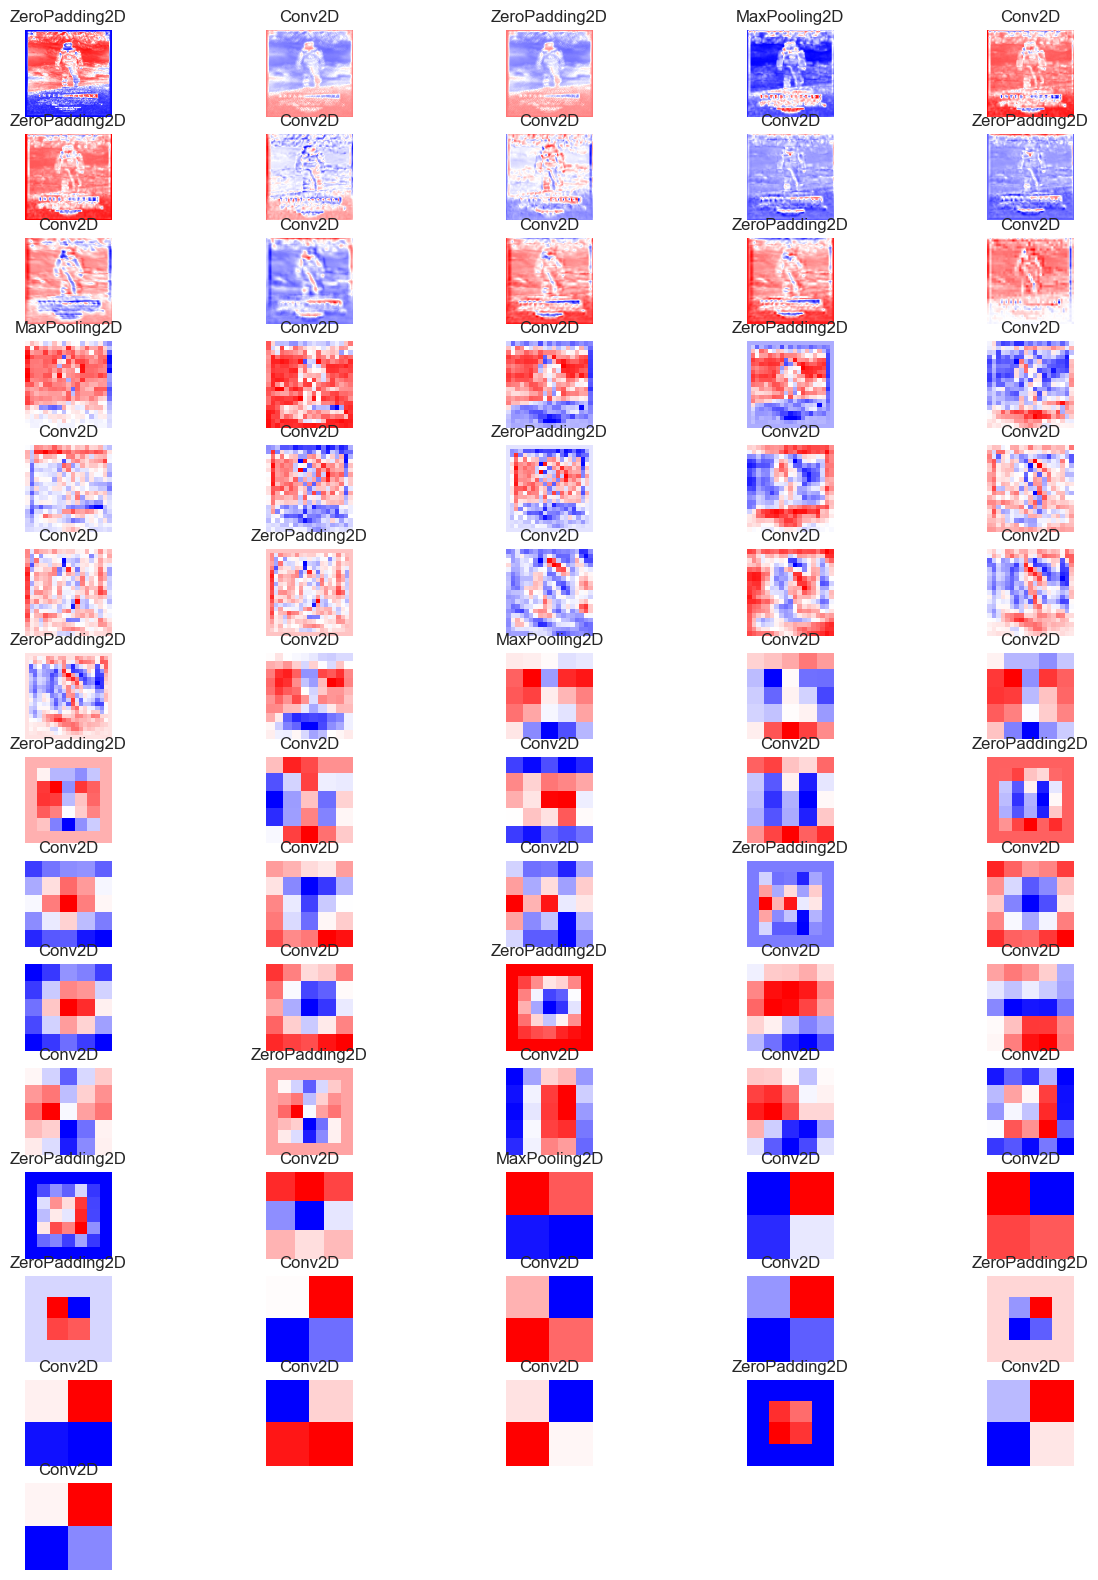

In [151]:
model = get_model('resnet', 'Adventure')
print('Model: resnet, Genre: Adventure')
get_model_feature_layers(model)

model = get_model('resnet', 'Horror')
print('Model: resnet, Genre: Horror')
get_model_feature_layers(model)

model = get_model('resnet', 'Family')
print('Model: resnet, Genre: Family')
get_model_feature_layers(model)

# Backup of other models
These models have been tested to but achieved less accurate results than resnet and custom poster model.

In [ ]:
def get_convnext_model():
    base_model = ConvNeXtSmall(include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    return Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2, noise_shape=None, seed=None),
        Dense(128, activation='relu'),
        Dense(2, activation='relu')  # Use sigmoid for multi-output regression
    ])

def get_custom_model(p_genres_to_predict):
    model = Sequential([
        Conv2D(16, kernel_size=(7,7), activation='relu', input_shape=(224, 224, 3)),
        Dropout(0.3),
        MaxPooling2D(3,3),
        BatchNormalization(),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        AveragePooling2D(7,7),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        AveragePooling2D(7,7),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def get_mobile_net(fine_tune = 2):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model (exclude fine tuning layers)
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
                layer.trainable = False
    else:
        for layer in base_model.layers:
                layer.trainable = False

    # Create a new model for genre prediction
    return Sequential([
        base_model,
        MaxPool2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='relu')
    ])

def get_efficient_model(p_genres_to_predict):
    # Define the number of output classes
    num_classes = len(p_genres_to_predict)
    # Load the pre-trained VGG16 model
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
    # Freeze the layers of the pre-trained model
    #for layer in base_model.layers:
    #    layer.trainable = False
    # Create a new model for genre prediction
    return Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2, noise_shape=None, seed=None),
        Dense(num_classes, activation='sigmoid')  # Use sigmoid for multi-output regression
    ])